# Furniture Total Quantity Sales Forecasting

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import itertools
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Load data file

In [37]:
train_df = pd.read_csv("ExistingCustomersTransactionsData.csv")

In [38]:
train_df.shape

(29982, 7)

In [39]:
train_df.columns

Index(['BillNumber', 'BillDate', 'CustomerID', 'ProductID', 'ProductCategory',
       'Sales', 'Quantity'],
      dtype='object')

### Choose only Furniture Product

In [40]:
furniture = train_df.loc[train_df['ProductCategory'] == 'Furniture']

In [41]:
furniture.shape

(6363, 7)

In [42]:
furniture['BillDate'].min(), furniture['BillDate'].max()

('2014-01-06', '2017-12-30')

### Drop other columns

In [43]:
cols = ['BillNumber','CustomerID','ProductID','ProductCategory','Sales']
furniture.drop(cols, axis=1, inplace=True)

C:\Users\Debasis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
furniture.head()

,BillDate,Quantity
17,2014-01-06,9
26,2014-01-06,9
35,2014-01-06,9
42,2014-01-07,3
44,2014-01-07,3


In [45]:
# Convert "BillDate" to datetime format
furniture["BillDate"] = pd.to_datetime(furniture["BillDate"], format='%Y-%m-%d')

C:\Users\Debasis\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [46]:
furniture.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6363 entries, 17 to 29979
Data columns (total 2 columns):
BillDate    6363 non-null datetime64[ns]
Quantity    6363 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 149.1 KB


In [47]:
furniture.index = furniture.BillDate

# Aggregate Quantity data monthly basis
furniture = furniture.resample('M').sum()

In [48]:
furniture.head()

,Quantity
BillDate,
2014-01-31,210
2014-02-28,69
2014-03-31,393
2014-04-30,243
2014-05-31,291


In [49]:
furniture['2017':]

,Quantity
BillDate,
2017-01-31,258
2017-02-28,213
2017-03-31,369
2017-04-30,525
2017-05-31,552
2017-06-30,528
2017-07-31,549
2017-08-31,381
2017-09-30,906


### Plot furniture data

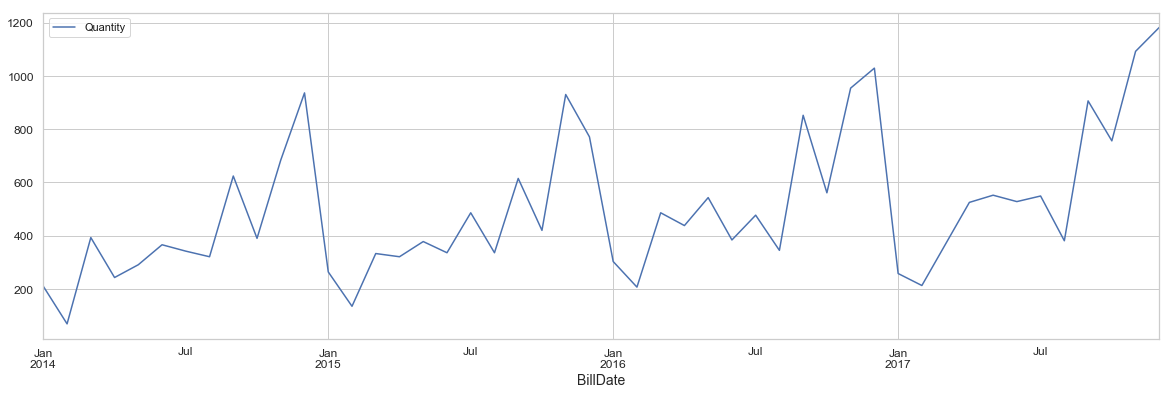

In [50]:
furniture.plot(figsize=(20, 6))
plt.show()

### Plot trend, seasonality, and noise.

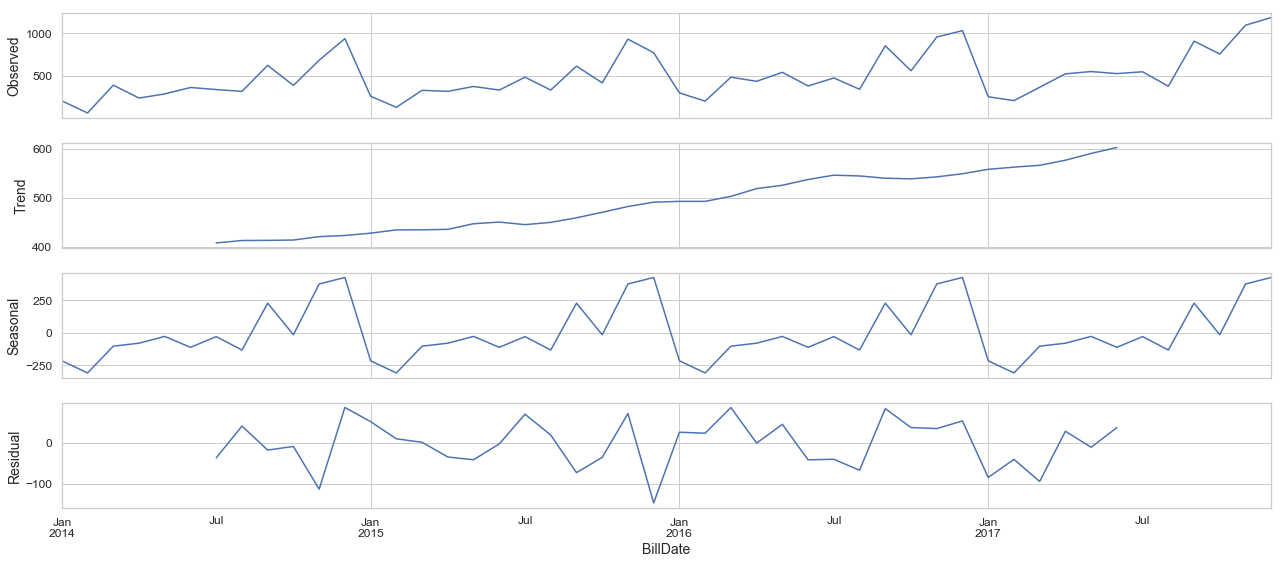

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(furniture, model='additive')
fig = decomposition.plot()
plt.show()

## Time series forecasting with ARIMA

In [52]:
# Generating parameter combination of seasonality, trend, and noise

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


### Grid Search to find the optimal set of parameters that yields the best performance for our model.

In [53]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(furniture,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:732.1449709528243


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1389.834764951512
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:434.9522910290901
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:434.8270071743497


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1300.9985465121927
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:301.3945496419233
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:687.1603889421729
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3050.7260462626705
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:424.065095465214
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:434.23623524475624
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2586.98839889183
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:301.5425236725699
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:647.6678896496314


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1312.2441206455592
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:437.0872507120172
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:449.35248162993906


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:802.7766502131134
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:283.47755191582365
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:627.9957370113682
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3105.2915096446236
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:401.9483225160793
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:427.6728712350648
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2599.320042833128
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:278.7609965126693
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:661.9409024332923
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1561.7387825005958
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:434.88258229064087
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:423.6135619691673


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1310.0652683410792
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:283.3819337710422
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:644.0494480747121
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3078.5514538691577
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:416.02643404184886
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:423.7107834573635
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2713.8182735147166
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:279.1134211992388
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:644.9277606110047


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:921.9980256061336
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:425.6196539196302
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:427.3909276879734


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1403.6231678454085
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:268.4476447033583
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:627.0643301822176
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2447.74225049881
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:403.4331536559237
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:417.2316409822009


C:\Users\Debasis\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2470.8145505685443
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:268.045331831602


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 268.04. Therefore we should consider this to be optimal option.

## Fitting the ARIMA model

In [54]:
mod = sm.tsa.statespace.SARIMAX(furniture,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1801      0.262      0.687      0.492      -0.334       0.694
ma.L1         -1.0000      0.393     -2.545      0.011      -1.770      -0.230
ar.S.L12      -0.3660      0.172     -2.122      0.034      -0.704      -0.028
sigma2      7200.2787   5.46e-05   1.32e+08      0.000    7200.279    7200.279


### Plotting Model diagnostics to investigate any unusual behavior

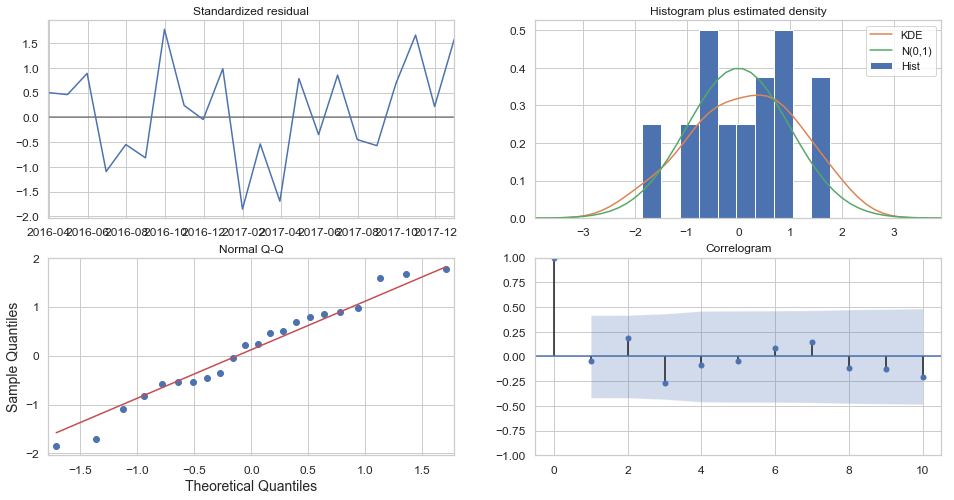

In [55]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

The above Model diagnostics suggests that the model residuals are near normally distributed.

## Validating forecasts

To understand the accuracy of our forecasts, we compare predicted quantity sales to real quantity sales of the time series, and we set forecasts to start at 2017–01–31 to the end of the data.

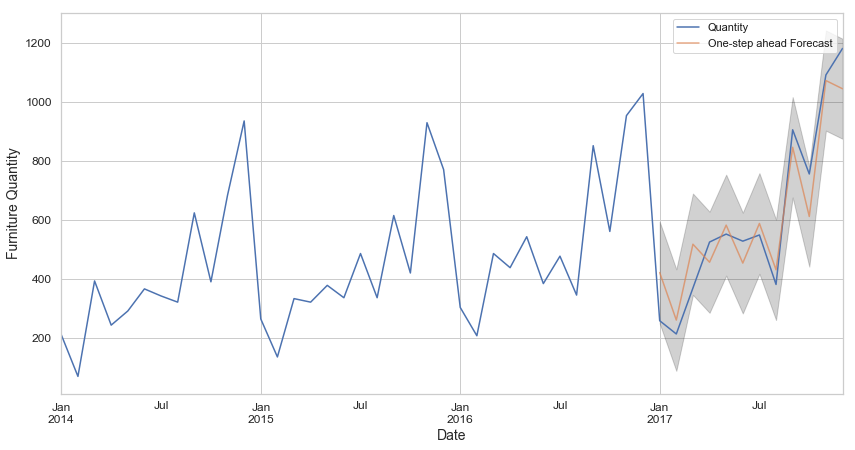

In [56]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Quantity')
plt.legend()
plt.show()

### Calculate RMSE

In [57]:
from math import sqrt
from sklearn.metrics import mean_squared_error
y_forecasted = pred.predicted_mean
y_truth = furniture['2017-01-31':]
rms = sqrt(mean_squared_error(y_truth,y_forecasted))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rms, 2)))

The Root Mean Squared Error of our forecasts is 95.56


## Producing and visualizing forecasts

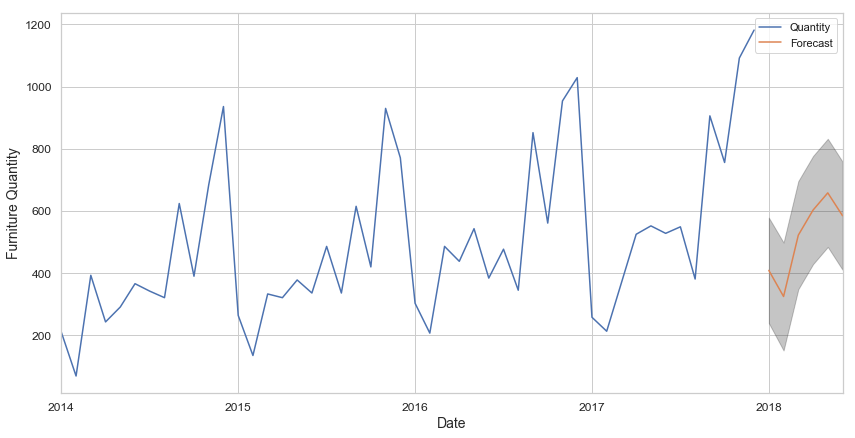

In [58]:
pred_uc = results.get_forecast(steps=6)

pred_ci = pred_uc.conf_int()
ax = furniture.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Quantity')
plt.legend()
plt.show()

In [59]:
# Resetting index
pred_ci = pred_ci.reset_index()
pred_ci.drop(['index'], axis=1, inplace=True)
pred_ci

,lower Quantity,upper Quantity
0,239.150091,578.479509
1,151.210000,498.344285
2,348.229871,696.034803
3,428.846874,776.749198
4,484.271145,832.190252
5,410.831876,758.753982


## Prediction result for next 6 months of year 2018

In [60]:
# Finding the mean value of lower & upper quantity sales monthly basis
result = (pred_ci.iloc[:, 0] + pred_ci.iloc[:, 1])/2
print(result)
result_df = pred_ci.copy()
result_df['month'] = range(1,7)
result_df['TotalQuantity'] = result

# Dropping "lower Quantity" & "upper Quantity" columns after generating "month" & "TotalQuantity" columns
result_df.drop(['lower Quantity', 'upper Quantity'], axis=1, inplace=True)

#Export to .csv file
result_df.to_csv('Result.csv', index=False)

0    408.814800
1    324.777142
2    522.132337
3    602.798036
4    658.230698
5    584.792929
dtype: float64
